Libraries

In [1]:
import math
import random
from copy import deepcopy
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import PauliFeatureMap
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.datasets import load_iris
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.algorithms import QSVC, PegasosQSVC
from qiskit_ibm_runtime import SamplerV2, QiskitRuntimeService, Session
from qiskit.primitives import StatevectorSampler as Sampler
import pickle

from sklearn.datasets import make_blobs, make_circles, make_moons
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import pandas as pd

Global parameters

In [2]:
# global GA parameters
POP_SIZE = 100
OFFSPRING_SIZE = 60
NUM_GENERATIONS = 80
CROSSOVER_PROB = 0.3
INDIVIDUAL_MUTATION_PROB = 0.7
BITFLIP_MUTATION_PROB = 0.25

N_SPLITS = 3
C = 1.0
PEGASOS_NUM_STEPS = 100

# gene_code parameters
GENE_LEN = 25  # fixed length base-4 chromosome
ALPH = [0, 1, 2, 3]

PAULI_CHAR = {0: 'I', 1: 'X', 2: 'Y', 3: 'Z'}
ENT_MAP = {0: 'full', 1: 'circular', 2: 'linear', 3: 'reverse_linear'}

SHOTS = 1024
OPTIMIZATION_LEVEL = 3

Datasets

 - synthetic datasets

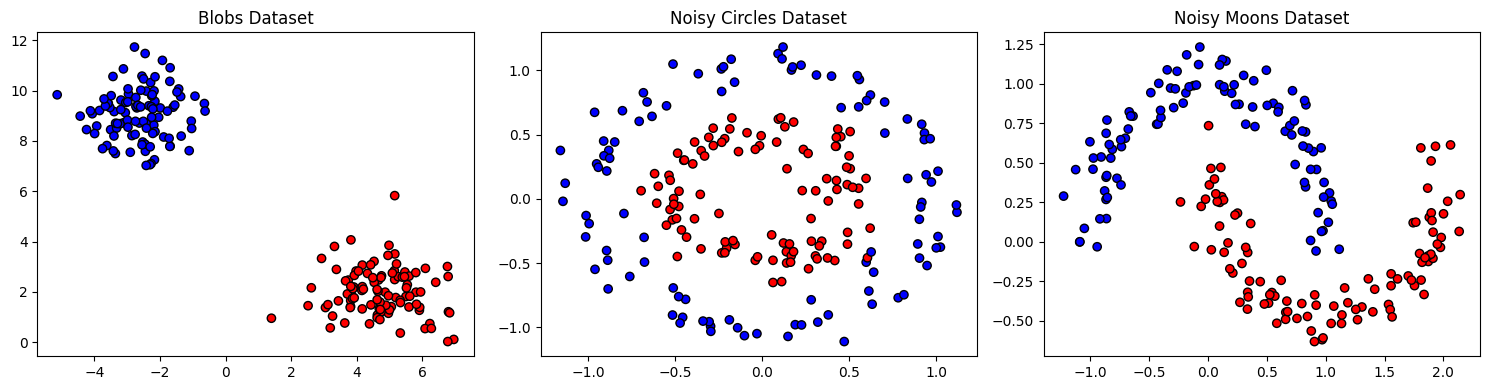

In [3]:
random_state = 42

# Generate the datasets
X_blobs, y_blobs = make_blobs(n_samples=200, centers=2, n_features=2, random_state=random_state)
X_circles, y_circles = make_circles(n_samples=200, noise=0.1, factor=0.5, random_state=random_state)
X_moons, y_moons = make_moons(n_samples=200, noise=0.1, random_state=random_state)

# Plot the datasets
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].scatter(X_blobs[:, 0], X_blobs[:, 1], c=y_blobs, cmap='bwr', edgecolors='k')
axes[0].set_title("Blobs Dataset")

axes[1].scatter(X_circles[:, 0], X_circles[:, 1], c=y_circles, cmap='bwr', edgecolors='k')
axes[1].set_title("Noisy Circles Dataset")

axes[2].scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap='bwr', edgecolors='k')
axes[2].set_title("Noisy Moons Dataset")

plt.tight_layout()
plt.show()

Classical evaluation of model

In [4]:
# Reproducibility
random_state = 42

# Generate datasets
datasets = {
    "blobs": make_blobs(n_samples=20, centers=2, n_features=2, random_state=random_state),
    "noisy_circles": make_circles(n_samples=20, noise=0.5, factor=0.5, random_state=random_state),
    "noisy_moons": make_moons(n_samples=20, noise=0.5, random_state=random_state),
}

# Define classical models
models = {
    "SVC linear": SVC(kernel='linear', random_state=random_state),
    "SVC poly": SVC(kernel='poly', degree=3, random_state=random_state),
    "SVC rbf": SVC(kernel='rbf', random_state=random_state)
}

# Store results
results = []

# Stratified K-Fold setup
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# Evaluate each model on each dataset
for model_name, model in models.items():
    for dataset_name, (X, y) in datasets.items():
        acc_scores = []
        f1_scores = []

        # Stratified K-Fold loop
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            acc_scores.append(accuracy_score(y_test, y_pred))
            f1_scores.append(f1_score(y_test, y_pred))

        acc_mean, acc_std = np.mean(acc_scores), np.std(acc_scores)
        f1_mean, f1_std = np.mean(f1_scores), np.std(f1_scores)

        results.append({
            "Type": "classical",
            "Model": model_name,
            "Dataset": dataset_name,
            "ACC": f"{acc_mean:.3f} ± {acc_std:.3f}",
            "F1": f"{f1_mean:.3f} ± {f1_std:.3f}"
        })

# Create results table
df_results = pd.DataFrame(results)

# Pivot for nice comparison
df_pivot = df_results.pivot(index=["Type", "Model"], columns="Dataset", values=["ACC", "F1"])

print("\nCross-validated results (mean ± std):\n")
print(df_pivot)



Cross-validated results (mean ± std):

                                ACC                                \
Dataset                       blobs  noisy_circles    noisy_moons   
Type      Model                                                     
classical SVC linear  1.000 ± 0.000  0.450 ± 0.292  0.750 ± 0.274   
          SVC poly    1.000 ± 0.000  0.500 ± 0.158  0.750 ± 0.000   
          SVC rbf     1.000 ± 0.000  0.550 ± 0.100  0.750 ± 0.224   

                                 F1                                
Dataset                       blobs  noisy_circles    noisy_moons  
Type      Model                                                    
classical SVC linear  1.000 ± 0.000  0.500 ± 0.297  0.693 ± 0.369  
          SVC poly    1.000 ± 0.000  0.340 ± 0.307  0.747 ± 0.065  
          SVC rbf     1.000 ± 0.000  0.567 ± 0.082  0.733 ± 0.226  


Genetic algorithm

In [5]:
# -------------------------
# Gene creation/qc building
# -------------------------

def decode_gene_to_pauli_params(gene):
    """
    a0 defines number of Pauli-strings = a0 + 1 (1..4)
    next 5*(a0+1) digits are blocks of 5 digits each:
        first digit of block -> string length encoding: val 0->1,1->2,2->3,3->4
        remaining 4 digits -> Pauli characters (up to 4, unused trailing ignored)
    last 4 digits control reps, entanglement, and alpha (two digits).
    """

    if len(gene) != GENE_LEN:
        raise ValueError("gene must be length 25")

    a = list(map(int, gene))
    a0 = a[0]
    num_strings = a0 + 1  # length of Pauli sequence (1..4)
    pauli_strings = []

    block_start = 1
    for block_idx in range(num_strings):
        base = block_start + block_idx * 5
        first_digit = a[base]  # encoding for string length: 0->1,1->2,2->3,3->4
        str_len = first_digit + 1
        # next 4 digits: characters
        chars = []
        for j in range(1, 5):
            val = a[base + j]
            chars.append(PAULI_CHAR[val])
        pauli_str = ''.join(chars[:str_len])
        pauli_strings.append(pauli_str)

    # last four digits indices 21..24
    a21, a22, a23, a24 = a[21], a[22], a[23], a[24]
    reps = a21 + 1  # 0->1,1->2,2->3,3->4
    ent = ENT_MAP.get(a22, 'full')
    # alpha encoded by two base-4 digits -> value in 0..15; mapping to ℓ=1..16
    l_val = 1 + 4 * int(a23) + int(a24)  # 1..16
    alpha = (l_val * math.pi) / 16.0

    return {
        "pauli_strings": pauli_strings,
        "reps": reps,
        "entanglement": ent,
        "alpha": alpha,
    }

def build_pauli_featuremap_from_gene(gene, num_qubits):
    params = decode_gene_to_pauli_params(gene)
    paulis = []
    for s in params["pauli_strings"]:
        # pad to num_qubits by appending I's on the right (apply on first |s| qubits)
        if len(s) < num_qubits:
            s_padded = s + 'I' * (num_qubits - len(s))
        elif len(s) > num_qubits:
            # truncate (the paper says strings are limited to N when N<4 by encoding rule)
            s_padded = s[:num_qubits]
        else:
            s_padded = s
        paulis.append(s_padded)

    # If no paulis, default to ['Z', 'Z' * num_qubits]
    if len(paulis) == 0:
        paulis = ['Z' * num_qubits]

    pfm = PauliFeatureMap(
        feature_dimension=num_qubits,
        reps=params["reps"],
        entanglement=params["entanglement"],
        paulis=paulis,
        alpha=params["alpha"],
        # maybe add data_map_func later
    )

    # Debugging info - uncomment if needed
    #if len(pfm.parameters) == 0:
    #    print(f"[WARN] PauliFeatureMap has NO parameters! gene={gene}")
    #    print(f"      params={params}")
    #    print(f"      paulis={paulis}")
    #    print(f"      feature_map type: {type(pfm)}")
    #   print(f"      num_qubits={num_qubits}")
    #    print("-" * 10)

    if len(pfm.parameters) < num_qubits:
        #print(f"[SKIP] Gene {gene} skipped: only {len(pfm.parameters)} parameters < {num_qubits} qubits")
        return None

    return pfm

# -------------------------
# Fitness / evaluation
# -------------------------
def evaluate_gene(gene, X, y, num_qubits, N_SPLITS, c, pegasos_num_steps):
    # create PauliFeatureMap from gene
    pfm = build_pauli_featuremap_from_gene(gene, num_qubits)

    #  Define cross-validation
    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

    accuracies = []
    f1_accuracies = []

    for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Define Kernel
        sampler = Sampler()
        fidelity = ComputeUncompute(sampler=sampler)
        qKernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=pfm)

        # Define and train model
        model = PegasosQSVC(quantum_kernel=qKernel, C=c, num_steps=pegasos_num_steps)
        model.fit(X_train, y_train)

        # Predict and evaluate
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        f1_accuracies.append(f1)
        accuracies.append(acc)

    # Overall metrics
    overall_acc = np.mean(accuracies)
    overall_acc_std = np.std(accuracies)
    overall_f1 = np.mean(f1_accuracies)
    overall_f1_std = np.std(f1_accuracies)

    print(f"Gene: {gene} -> Acc: {overall_acc:.4f} (+/- {overall_acc_std:.4f}), F1: {overall_f1:.4f} (+/- {overall_f1_std:.4f})")
    return overall_acc

# -------------------------
# Genetic Algorithm
# -------------------------

def random_gene():
    return [random.choice(ALPH) for _ in range(GENE_LEN)]

def is_gene_valid(gene, num_qubits, require_nontrivial=True):
    try:
        params = decode_gene_to_pauli_params(gene)
    except Exception:
        return False

    pauli_strings = params.get("pauli_strings", [])
    if len(pauli_strings) == 0:
        return False
    
    if require_nontrivial:
        nontrivial_found = False
    for s in pauli_strings:
        # only the first len(s) chars are meaningful before padding/truncation
        meaningful = s[:min(len(s), num_qubits)]
        # if any of the meaningful chars is not 'I', it's nontrivial
        if any(ch != 'I' for ch in meaningful):
            nontrivial_found = True
            break
    if not nontrivial_found:
        return False
    
    return True

def valid_random_gene(num_qubits, max_attempts=200):
    a = [0] * GENE_LEN

    for attempt in range(max_attempts):
        a0 = random.choice([0,1,2,3])  # 0->1 string, 3->4 strings
        a[0] = a0
        num_strings = a0 + 1

        # For each block (5 digits): first digit encodes string length: 0->1,1->2,2->3,3->4
        # We must ensure str_len <= num_qubits => first_digit <= num_qubits - 1
        max_first_digit = min(3, max(0, num_qubits - 1))
        block_start = 1
        for block_idx in range(num_strings):
            base = block_start + block_idx * 5

            # choose a first_digit so that length <= num_qubits
            first_digit = random.randint(0, max_first_digit)
            a[base] = first_digit
            str_len = first_digit + 1  # 1..min(4,num_qubits)

            # choose characters for the 4 slots.
            # ensure at least one of the first str_len characters is non-identity (1..3)
            # fill remaining char slots (up to 4) arbitrarily (can be identity too)
            meaningful_positions = list(range(str_len))
            # select one position among meaningful positions to be non-identity
            nonid_pos = random.choice(meaningful_positions)
            for j in range(1, 5):
                if j-1 == nonid_pos:
                    a[base + j] = random.choice([1,2,3])  # X/Y/Z
                elif j <= str_len:
                    # meaningful but may be I or non-I (add some randomness)
                    a[base + j] = random.choice([0,1,2,3])
                else:
                    # unused positions in block -> keep random (allowed)
                    a[base + j] = random.choice([0,1,2,3])

        # For any remaining blocks (if num_strings < 4) fill them with innocuous values:
        # we still need to fill all 4 blocks (5 digits each) so gene length is 1 + 4*5 + 4 = 25.
        # If we didn't touch block indices beyond num_strings, fill them with zeros.
        for block_idx in range(num_strings, 4):
            base = block_start + block_idx * 5
            # set first digit to 0 (length 1) and chars to identity 'I' (0) to be minimal
            a[base] = 0
            for j in range(1,5):
                a[base + j] = 0

        # Last four digits control reps, ent, alpha (a21..a24)
        # a21 reps: 0..3  => 1..4 repetitions
        a21 = random.randint(0, 3)
        a[21] = a21
        # a22 entanglement: 0..3
        a[22] = random.randint(0, 3)
        # a23, a24 alpha digits base-4
        a[23] = random.randint(0, 3)
        a[24] = random.randint(0, 3)

        # Quick validation: does this gene decode to a usable one?
        if is_gene_valid(a, num_qubits, require_nontrivial=True):
            return a

    raise RuntimeError(f"Unable to generate a valid gene for num_qubits={num_qubits} after {max_attempts} attempts.")

#def init_population(mu):
#    return [random_gene() for _ in range(mu)]

def init_population(mu, num_qubits):
    pop = []
    for _ in range(mu):
        pop.append(valid_random_gene(num_qubits))
    return pop

def tournament_select(pop, fitnesses, k=5):
    idxs = random.sample(range(len(pop)), k)
    best = max(idxs, key=lambda i: fitnesses[i])
    return deepcopy(pop[best])

def single_point_crossover(a, b):
    n = len(a)
    if n <= 1: return deepcopy(a), deepcopy(b)
    pt = random.randint(1, n-1)
    c1 = a[:pt] + b[pt:]
    c2 = b[:pt] + a[pt:]
    return c1, c2

def mutate(gene, pm=0.02):
    g = gene[:]
    for i in range(len(g)):
        if random.random() < pm:
            g[i] = random.choice(ALPH)
    return g

"""
def ga_search(X, y, num_qubits, mu=10, lam=20, generations=10, backend=None,
              crossover_prob=0.8, mutation_prob=0.05, complexity_weight=0.05, verbose=True):
    backend = backend or AerSimulator(method='statevector')
    population = init_population(mu)
    # evaluate initial population
    fitnesses = []
    for g in population:
        fitnesses.append(evaluate_gene(g, X, y, num_qubits, backend=backend, complexity_weight=complexity_weight))
    for gen in range(generations):
        if verbose:
            print(f"=== Generation {gen+1}/{generations} ===")
        # create lam offspring
        offspring = []
        while len(offspring) < lam:
            p1 = tournament_select(population, fitnesses)
            p2 = tournament_select(population, fitnesses)
            if random.random() < crossover_prob:
                c1, c2 = single_point_crossover(p1, p2)
            else:
                c1, c2 = deepcopy(p1), deepcopy(p2)
            c1 = mutate(c1, mutation_prob)
            c2 = mutate(c2, mutation_prob)
            offspring.append(c1)
            if len(offspring) < lam:
                offspring.append(c2)
        # evaluate offspring
        off_fitnesses = []
        for g in offspring:
            off_fitnesses.append(evaluate_gene(g, X, y, num_qubits, backend=backend, complexity_weight=complexity_weight))
        # combine and pick top-mu by fitness[0] (score)
        combined = list(zip(population + offspring, fitnesses + off_fitnesses))
        combined.sort(key=lambda t: t[1][0], reverse=True)  # maximize score
        population = [deepcopy(ind) for (ind, fit) in combined[:mu]]
        fitnesses = [fit for (ind, fit) in combined[:mu]]
        if verbose:
            best = fitnesses[0]
            print(f" Best score={best[0]:.4f} acc={best[1]:.4f} complexity={best[2]:.1f}")
    # final best individual (highest score)
    best_ind = population[0]
    best_fit = fitnesses[0]
    return best_ind, best_fit
"""

def save_ga_state(filename, population, fitnesses, generation):
    state = {
        'population': population,
        'fitnesses': fitnesses,
        'generation': generation
    }
    with open(filename, 'wb') as f:
        pickle.dump(state, f)
    print(f"[INFO] GA state saved to {filename}")

def ga_search(X, y, num_qubits, mu=10, lam=20, generations=10, crossover_prob=0.8, mutation_prob=0.05, verbose=True):
    """
    (mu + lambda) Genetic Algorithm optimizing for classification accuracy.
    """
    print(f"=== Initial Generation ===")
    #population = init_population(mu)
    population = init_population(mu, num_qubits)

    # Evaluate initial population
    #fitnesses = [evaluate_gene(g, X, y, num_qubits, backend=backend) for g in population]
    fitnesses = [evaluate_gene(g, X, y, num_qubits, N_SPLITS, C, PEGASOS_NUM_STEPS) for g in population]

    for gen in range(generations):
        if verbose:
            print(f"=== Generation {gen+1}/{generations} ===")

        # Create offspring
        offspring = []
        while len(offspring) < lam:
            p1 = tournament_select(population, fitnesses)
            p2 = tournament_select(population, fitnesses)
            if random.random() < crossover_prob:
                c1, c2 = single_point_crossover(p1, p2)
            else:
                c1, c2 = deepcopy(p1), deepcopy(p2)
            c1 = mutate(c1, mutation_prob)
            c2 = mutate(c2, mutation_prob)
            
            # check validity of offspring genes
            if not is_gene_valid(c1, num_qubits):
                c1 = valid_random_gene(num_qubits)
            if not is_gene_valid(c2, num_qubits):
                c2 = valid_random_gene(num_qubits)

            offspring.extend([c1, c2][:lam - len(offspring)])

        # Evaluate offspring
        #off_fitnesses = [evaluate_gene(g, X, y, num_qubits, backend=backend) for g in offspring]
        off_fitnesses = [evaluate_gene(g, X, y, num_qubits, N_SPLITS, C, PEGASOS_NUM_STEPS) for g in offspring]

        # Select best mu individuals by accuracy
        combined = list(zip(population + offspring, fitnesses + off_fitnesses))
        combined.sort(key=lambda t: t[1], reverse=True)  # maximize accuracy
        population = [deepcopy(ind) for ind, _ in combined[:mu]]
        fitnesses = [fit for _, fit in combined[:mu]]

        if verbose:
            print(f" Best accuracy = {fitnesses[0]:.4f}")
        
        save_ga_state('ga_progress.pkl', population, fitnesses, gen)

    best_ind = population[0]
    best_acc = fitnesses[0]
    return best_ind, best_acc


Usage

In [58]:
if __name__ == "__main__":
    POP_SIZE = 8
    OFFSPRING_SIZE = 5
    NUM_GENERATIONS = 5
    CROSSOVER_PROB = 0.3
    INDIVIDUAL_MUTATION_PROB = 0.7
    BITFLIP_MUTATION_PROB = 0.25

    N_SPLITS = 3
    C = 1.0
    PEGASOS_NUM_STEPS = 100

    X_circles, y_circles = make_circles(n_samples=10, noise=0.5, random_state=random_state)
    num_qubits = X_circles.shape[1]
    best_gene, best_acc = ga_search(
        X_circles, y_circles, num_qubits,
        mu=POP_SIZE,
        lam=OFFSPRING_SIZE,
        generations=NUM_GENERATIONS,
        crossover_prob=CROSSOVER_PROB,
        mutation_prob=INDIVIDUAL_MUTATION_PROB,
        verbose=True
    )
    print(f"Best gene: {best_gene} with accuracy: {best_acc:.4f}")

    

=== Initial Generation ===
Gene: [2, 1, 3, 0, 1, 2, 0, 1, 0, 2, 3, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 1, 1, 0, 3] -> Acc: 0.4722 (+/- 0.1964), F1: 0.4333 (+/- 0.3300)
Gene: [2, 1, 1, 1, 1, 0, 0, 2, 0, 3, 1, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 2, 2, 2] -> Acc: 0.3889 (+/- 0.0786), F1: 0.3889 (+/- 0.2833)
Gene: [0, 0, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 2, 2] -> Acc: 0.5000 (+/- 0.1361), F1: 0.6556 (+/- 0.1227)
Gene: [0, 1, 1, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 3] -> Acc: 0.3889 (+/- 0.0786), F1: 0.3889 (+/- 0.2833)
Gene: [1, 0, 2, 2, 0, 1, 1, 3, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1] -> Acc: 0.5556 (+/- 0.3143), F1: 0.5000 (+/- 0.4082)
Gene: [3, 0, 2, 3, 0, 2, 0, 1, 0, 0, 1, 0, 3, 1, 0, 0, 0, 2, 1, 2, 1, 0, 2, 0, 1] -> Acc: 0.3889 (+/- 0.0786), F1: 0.0000 (+/- 0.0000)
Gene: [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 1] -> Acc: 0.3889 (+/- 0.0786), F1: 0.5556 (+/- 0.0786)
Gene: [1, 0, 1, 2, 1, 3, 0, 

TypeError: random_gene() takes 0 positional arguments but 1 was given

Known feature map

In [11]:
def metrics_from_model(X_test, y_test):
    num_qubits = 2
    paulis = ['IX', 'XX', 'YX']
    #params = {
    #    "reps": 4,
    #    "entanglement": "circular",
    #    "alpha": 2.748894
    #}
    params = {
        "reps": 1,
        "entanglement": "linear",
        "alpha": 1.1780972450961724
    }

    pfm = PauliFeatureMap(
        feature_dimension=num_qubits,
        reps=params["reps"],
        entanglement=params["entanglement"],
        paulis=paulis,
        alpha=params["alpha"],
    )
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    #K_test = quantum_kernel(pfm, X_test)
    # Train and predict
    #model = SVC(kernel='precomputed', C=1.0)
    sampler = Sampler()
    fidelity = ComputeUncompute(sampler=sampler)
    qKernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=pfm)
    #model = QSVC(quantum_kernel=qKernel, C = 0.1)
    model = PegasosQSVC(quantum_kernel=qKernel, C=1, num_steps=100) # is way faster
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Final model metrics - ACC: {acc:.4f}, F1: {f1:.4f}")

    return {"ACC": acc, "F1": f1}

In [16]:
if __name__ == "__main__":
    #X_circles, y_circles = make_circles(n_samples=20, noise=0.5, random_state=random_state)
    #from sklearn.preprocessing import MinMaxScaler
    #X_circles = MinMaxScaler(feature_range=(0, np.pi)).fit_transform(X_circles)

    #metrics = metrics_from_model(X_blobs, y_blobs)
    #metrics = metrics_from_model(X, y)
    gene = [2, 1, 0, 1, 2, 1, 3, 1, 1, 1, 1, 2, 2, 1, 0, 3, 1, 0, 1, 3, 2, 1, 2, 1, 1]
    #num_qubits = 2
    #print(build_pauli_featuremap_from_gene(gene, num_qubits))
    N_SPLITS = 4
    metric = evaluate_gene(gene, X, y, num_qubits, N_SPLITS, C, PEGASOS_NUM_STEPS)

Gene: [2, 1, 0, 1, 2, 1, 3, 1, 1, 1, 1, 2, 2, 1, 0, 3, 1, 0, 1, 3, 2, 1, 2, 1, 1] -> Acc: 0.7000 (+/- 0.2236), F1: 0.7179 (+/- 0.1970)


In [8]:
gene = [2, 1, 0, 1, 2, 1, 3, 1, 1, 1, 1, 2, 2, 1, 0, 3, 1, 0, 1, 3, 2, 1, 2, 1, 1]
# convert to string
# define again map as the original function
converted_gene = ''.join(map(str, gene))
print(converted_gene)
pauli_params = decode_gene_to_pauli_params(converted_gene)
print(pauli_params)

2101213111122103101321211
{'pauli_strings': ['IX', 'XXXX', 'YXI'], 'reps': 2, 'entanglement': 'linear', 'alpha': 1.1780972450961724}
